<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Train_polyphonic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
%%capture
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt
#!pip install partitura
! pip install git+https://github.com/CPJKU/partitura.git@develop
import partitura
import statistics
import matplotlib



!git clone https://github.com/aim56009/AI-MA_project.git

#Dataloader - Set the dataset

In [2]:
PATH_TO_DATA = "AI-MA_project/pr_polyphonic"

batch_size = 1 
workers = 0

In [3]:
from scipy import sparse

In [4]:
max_len_load = 3000

class MusicDataset_polyphonic(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir
        piece_lengths = ["2_voice","4_voice"]
        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []
        file_names_list = []

        counter_files_v2 = 0

        for v_len_idx in piece_lengths:
            if v_len_idx == "4_voice":
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))       
                        for name in file_names:
                            with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                                loaded_obj = pickle.load(f)  

                                #print("loaded_obj before:",loaded_obj.shape)

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]
                            

                                #print("loaded_obj after:",loaded_obj.shape)

                                voice_files.append(sparse.csr_matrix(loaded_obj))

                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(4)                        

                        self.pr_dict[self.labels[iLabel]] += voice_files
                        self.pr_dict["length"] +=  len_list
                        self.pr_dict["nbr_voices"] +=  nbr_voices_list
                        self.pr_dict["name"] += file_names_list
                   
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]


                                  voice_files.append(sparse.csr_matrix(loaded_obj))
                        self.pr_dict[self.labels[iLabel]] += voice_files


            if v_len_idx == "2_voice":
              #if counter_files_v2 < len(sorted(glob.glob(os.path.join(PATH_TO_DATA, "4_voice" , self.labels[4], "*.pkl")))):     ############### load as many 2 voice pieces as 4 voice pieces    ##########
                #counter_files_v2 +=1
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))   
                        for name in file_names:
                            with open(name ,'rb') as f:
                                loaded_obj = pickle.load(f)  

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]

                                voice_files.append(sparse.csr_matrix(loaded_obj))
                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(2)
                              
                        self.pr_dict[self.labels[iLabel]] = voice_files
                        self.pr_dict["length"] = len_list
                        self.pr_dict["nbr_voices"] = nbr_voices_list
                        self.pr_dict["name"] = file_names_list
    
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)   

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]

                                  voice_files.append(sparse.csr_matrix(loaded_obj))  
                        self.pr_dict[self.labels[iLabel]] = voice_files
                    
    def __len__(self):
        file_names_2 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "2_voice" , self.labels[4], "*.pkl")))
        file_names_4 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "4_voice" , self.labels[4], "*.pkl")))
        return len(file_names_2) + len(file_names_4) 

    def __getitem__(self, idx):      
        out_list = []
        for key,value in self.pr_dict.items():
          v0 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_0"][idx]).T)
          v1 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_1"][idx]).T)
          
          if self.pr_dict["nbr_voices"][idx] == 4:       ### -168 WORKS ONLY IN THIS CASE BC 168 SAMPLES OF LEN(2) ARE LOADED FIRST
              v2 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_2"][idx-168]).T)
              v3 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_3"][idx-168]).T)
          if self.pr_dict["nbr_voices"][idx] == 2:
              v2 = torch.zeros(v1.shape)
              v3 = torch.zeros(v1.shape)
          
          v_all = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_all"][idx]).T)
          length = self.pr_dict["length"][idx]
          nbr_voices = self.pr_dict["nbr_voices"][idx]
          file_name = self.pr_dict["name"][idx]
          voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)

        return (voices, length, nbr_voices, file_name)

## Plots


In [5]:
"""
dataset = MusicDataset_polyphonic(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\ndataset = MusicDataset_polyphonic(PATH_TO_DATA)\nloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [6]:
"""
for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [7]:
"""
pianoroll_0 = all_voices.squeeze()[:,:,0].numpy()
pianoroll_1 = all_voices.squeeze()[:,:,1].numpy()
pianoroll_2 = all_voices.squeeze()[:,:,2].numpy()
pianoroll_3 = all_voices.squeeze()[:,:,3].numpy()
pianoroll_all = all_voices.squeeze()[:,:,-1].numpy()

colors_0 = 'none red'.split()
colors_1 = 'none green'.split()
colors_2 = 'none blue'.split()
colors_3 = 'black orange'.split()

cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)
cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_1[3000:4000,:], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_0[3000:4000,:], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({"beat"}s/{12})')
ax.set_ylabel('Piano key')
plt.show()
"""

'\npianoroll_0 = all_voices.squeeze()[:,:,0].numpy()\npianoroll_1 = all_voices.squeeze()[:,:,1].numpy()\npianoroll_2 = all_voices.squeeze()[:,:,2].numpy()\npianoroll_3 = all_voices.squeeze()[:,:,3].numpy()\npianoroll_all = all_voices.squeeze()[:,:,-1].numpy()\n\ncolors_0 = \'none red\'.split()\ncolors_1 = \'none green\'.split()\ncolors_2 = \'none blue\'.split()\ncolors_3 = \'black orange\'.split()\n\ncmap_0 = matplotlib.colors.ListedColormap(colors_0, name=\'colors\', N=None)\ncmap_1 = matplotlib.colors.ListedColormap(colors_1, name=\'colors\', N=None)\ncmap_2 = matplotlib.colors.ListedColormap(colors_2, name=\'colors\', N=None)\ncmap_3 = matplotlib.colors.ListedColormap(colors_3, name=\'colors\', N=None)\n\nfig, ax = plt.subplots(1, figsize=(20, 10))\n\nax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(piano

#Define U-Net

In [8]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList([self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList([nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2) for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList([self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        y = x
        concat_layers = concat_layers[::-1]

        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x, y

# Define Network


In [9]:
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=88, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)

        self.input_unet = int(np.floor(max_len_load/2/2/2/2)*1024*5)
        self.clf_head = nn.Linear(self.input_unet, 4)                         ################   4 bc max nbr voices ==4 in our dataset
        self.clf_head_gap = nn.Linear(1024, 128)
        self.clf_head_gap_2 = nn.Linear(128, 4)
        self.indicator = 0

    

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)     
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

          return torch.stack([out_0, out_1, out_2, out_3], dim=1)

        else: 
          sentences = sentences[:,None]
          out, down_state = self.cnn(sentences)

          self.down_state = down_state

          ############### try implementing GAP ###############
          #print("down_state",down_state.shape)
          gap = nn.AdaptiveAvgPool2d((1,1))
          input = down_state
          gap_reduced = gap(input).squeeze()
          #print(gap_reduced.shape)
          out_clf_head = self.clf_head_gap_2(self.clf_head_gap(gap_reduced))
          #print("self.clf_head_gap(gap_reduced)",self.clf_head_gap(gap_reduced))
          ######################################################

          return out, out_clf_head  
          """
          if self.input_unet == torch.flatten(down_state).shape[0]:
            self.indicator = 1
            out_clf_head = self.clf_head(torch.flatten(down_state))
            return out, out_clf_head                
          else:      ### in case input is smaller than 5000
            self.indicator = 0
            return out, None        
          """                              
        

    def forward(self, voices, sentences_len, nbr_voices):            
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_comb, out_clf_head = self.compute_outputs(voices[:,:,:,-1], sentences_len)

        # Flatten the outputs and the labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        score_0  = scores_comb[:,0,:,:].view(-1, self.n_out)
        score_1  = scores_comb[:,1,:,:].view(-1, self.n_out)
        score_2  = scores_comb[:,2,:,:].view(-1, self.n_out)
        score_3  = scores_comb[:,3,:,:].view(-1, self.n_out)

        clf_score = out_clf_head.softmax(dim=0)
        clf_label = nbr_voices[0]-1
        define_clf_loss = nn.CrossEntropyLoss(reduction='mean')
        loss_clf = define_clf_loss(clf_score, clf_label)

        print("loss_clf",loss_clf)
 

        weight_v0 = voices[:,:,:,0].squeeze().sum()
        weight_v1 = voices[:,:,:,1].squeeze().sum()
        weight_v2 = voices[:,:,:,2].squeeze().sum()
        weight_v3 = voices[:,:,:,3].squeeze().sum()

        stack_tensors_gt = torch.swapaxes(torch.swapaxes(voices[:,:,:,:4].squeeze(), 0, 2), 1,2)
        stack_gt = torch.argmax(stack_tensors_gt,axis=0)

        
        weight_tensor = torch.stack([weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0])
        criterion_weighted = nn.CrossEntropyLoss(weight=weight_tensor,reduction='mean',ignore_index=99)  
        stack_pred = torch.stack([score_0, score_1, score_2, score_3], dim=0).softmax(dim=0)[None, :]
        mask_pred = torch.squeeze(voices[:,:,:,-1])== 0
        stack_gt[mask_pred] = 99
        loss = criterion_weighted(stack_pred, stack_gt[None,:])

        if torch.any(torch.isnan(stack_pred)) or torch.any(torch.isinf(stack_pred)) :
          print('invalid input detected at iteration ')

        return loss + loss_clf


    def predict(self, sentences, sentences_len,monophonic=True):
        scores_comb, out_clf_head = self.compute_outputs(sentences, sentences_len)
        sum_tensor = scores_comb * sentences[:,None,:,:]
        prediction = np.squeeze(sum_tensor.cpu().numpy())                # prediction is of shape 4,T,88 and contains a probability for the result to belong to one of the 4 voices -> taking argmax: gives the voice with the highes probability
        v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
        
        mask_pred = np.squeeze(sentences)== 0
        v_pred_argm[mask_pred] = -1

        ### only output if clf is not none ####       ####!!!!!!!!!NNEEEED TO TEST AGAIN !!!!
        clf_score = out_clf_head.softmax(dim=0)
        pred_clf = torch.argmax(clf_score,axis=0)              

        return v_pred_argm, pred_clf   

In [10]:
"""
monophonic = True
his = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)
"""

'\nmonophonic = True\nhis = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)\n'

# Define Training Process

In [11]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 88
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)

    history = training_loop(model, optimizer, train_dataloader,monophonic, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

# Tryining Loop

In [12]:
#### versuch hier mal nur für 4 voices zu trainieren

def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        loss_sum_clf = 0
        model.train()
                
        for idx, (voices, lens, nbr_voices, _) in enumerate(train_dataloader):  
            #if nbr_voices == 4:
            #if idx < 80:
              voices = voices.to(device).float()
              optimizer.zero_grad()
              loss = model.forward(voices, lens, nbr_voices)
              print("sample {} / {}".format(idx,len(train_dataloader)))           
              print("loss:",loss)
              loss.backward()
              optimizer.step()
              loss_sum += loss.item()  

        train_loss = loss_sum / len(train_dataloader)
        print("Epoch: {}, Train Loss: {}".format(i_epoch,train_loss)) 

        if scheduler is not None:
            scheduler.step()
        
    torch.save({'model_state_dict': model.state_dict()}, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [13]:
def start_experiment( epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    
    trainer = partial(train,epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        print("train_dataloader",len(train_dataloader),"val_dataloader",len(val_dataloader))
        _, history = trainer(train_dataloader, val_dataloader)

    return history, val_dataloader

# Hyperparameter choice

In [14]:
model = MusicNetwork
epochs = 1
lr = 0.001 # was 0.001    #0.00001
momentum = 0.9
decay = 1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train and valid set
network_type= "CNN" # with clf head: "CNN_CLF"

monophonic = True

# Run the experiment

In [15]:
his, val_dataloader = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

train_dataloader 260 val_dataloader 46
Adjusting learning rate of group 0 to 1.0000e-04.
Training on device: cpu
loss_clf tensor(1.3920, grad_fn=<NllLossBackward0>)
sample 0 / 260
loss: tensor(2.7936, grad_fn=<AddBackward0>)
loss_clf tensor(1.0015, grad_fn=<NllLossBackward0>)
sample 6 / 260
loss: tensor(2.3919, grad_fn=<AddBackward0>)
loss_clf tensor(0.7953, grad_fn=<NllLossBackward0>)
sample 10 / 260
loss: tensor(2.1783, grad_fn=<AddBackward0>)
loss_clf tensor(0.7509, grad_fn=<NllLossBackward0>)
sample 11 / 260
loss: tensor(2.1185, grad_fn=<AddBackward0>)
loss_clf tensor(0.7449, grad_fn=<NllLossBackward0>)
sample 12 / 260
loss: tensor(2.1140, grad_fn=<AddBackward0>)
loss_clf tensor(0.7439, grad_fn=<NllLossBackward0>)
sample 14 / 260
loss: tensor(2.1202, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
sample 15 / 260
loss: tensor(2.1182, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
sample 17 / 260
loss: tensor(2.1009, grad_fn=<

# Load trained model

In [16]:
dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
#train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

In [17]:
train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

val_dataloader

In [18]:
len(val_dataloader)

46

In [19]:
%%capture  
output_dim = 88
model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)  
checkpoint = torch.load("./AI-MA_project/model_temp_epoch1.pkl")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create dic with key:filename, val: part_obj  

In [20]:
#%%capture

path_parts = "AI-MA_project/polyphonic_new"
part_dic = {}

#### create a list with all filenames in the right order ####
file_names_part = []

for filename in sorted(os.listdir(path_parts)):
    if not filename.endswith('.mid'): continue
    file_names_part.append(filename[9:12])
print(file_names_part)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145'

# Compute polyphonic accuracy

In [47]:
def evaluate_accuracy_polyphonic_separate(model, train_dataloader, part_dic,print_predictions=False):

    unitl_len_idx = max_len_load

    path_parts = "AI-MA_project/polyphonic_new"
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict_two = {'0': [], '1': [] }
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
        #print("nbr_voices:",nbr_voices)
        if idx not in [3, 14, 20, 21, 23, 31, 34, 35, 41, 45]:   
            print("idx:",idx)
            if nbr_voices == 4:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                part_2 = part[2]
                part_3 = part[3]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)              
                note_array_2 = partitura.utils.note_array_from_part(part_2)
                note_array_3 = partitura.utils.note_array_from_part(part_3)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                ground_truth_label_list = [0,1,2,3]    
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
            
                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)


                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]
                        print("prediction number of voices:",prediction_clf+1)
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)

                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")

                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (10, 5)

                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')

                    ax.set_title("PREDICTED: red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()

                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()
                    pr_two = partitura.utils.compute_pianoroll(part_2, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_two = pr_two.toarray()
                    pr_three = partitura.utils.compute_pianoroll(part_3, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_three = pr_three.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_two[:,:unitl_len_idx], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_three[:,:unitl_len_idx], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    
                    
                        
                    ax.set_title("ORIGINAL: red-v0, green-v1 ,blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key' )
                    plt.show()

                
                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }
                for gt, i in enumerate(total_predictions_dict.keys()):
                    counting = 0
                    for j in range(len(total_predictions_dict[i])):
                        if total_predictions_dict[i][j][0] == gt:         
                            counting +=1
                    count_dict_2[i].append(counting)

                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                
                
                ########## COMPARE HERE EACH PREDICTION ALWAYS WITH ALL VOICES !!!   ##########
                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }
                intermed_dict = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                  intermed_dict = {'0': [], '1': [], '2': [], '3': [] } 
                  for j in range(len(total_predictions_dict[i])):
                    for idx_tr, tr in enumerate([0,1,2,3]):
                      if total_predictions_dict[i][j][0] == tr:
                        intermed_dict[list(intermed_dict.keys())[idx_tr]].append(1)
                  sum_0 = np.array([intermed_dict["0"]]).sum()
                  sum_1 = np.array([intermed_dict["1"]]).sum()
                  sum_2 = np.array([intermed_dict["2"]]).sum()
                  sum_3 = np.array([intermed_dict["3"]]).sum()
                  count_dict_2[list(count_dict_2.keys())[gt]] = intermed_dict


                hit_list_0 = [np.array([count_dict_2["0"]["0"]]).sum(),np.array([count_dict_2["0"]["1"]]).sum(),np.array([count_dict_2["0"]["2"]]).sum(),np.array([count_dict_2["0"]["3"]]).sum() ]
                hit_list_1 = [np.array([count_dict_2["1"]["0"]]).sum(),np.array([count_dict_2["1"]["1"]]).sum(),np.array([count_dict_2["1"]["2"]]).sum(),np.array([count_dict_2["1"]["3"]]).sum() ]
                hit_list_2 = [np.array([count_dict_2["2"]["0"]]).sum(),np.array([count_dict_2["2"]["1"]]).sum(),np.array([count_dict_2["2"]["2"]]).sum(),np.array([count_dict_2["2"]["3"]]).sum() ]
                hit_list_3 = [np.array([count_dict_2["3"]["0"]]).sum(),np.array([count_dict_2["3"]["1"]]).sum(),np.array([count_dict_2["3"]["2"]]).sum(),np.array([count_dict_2["3"]["3"]]).sum() ]  

                hit_list_temp_0 = hit_list_0.copy()
                hit_list_temp_1 = hit_list_1.copy()
                hit_list_temp_2 = hit_list_2.copy()
                hit_list_temp_3 = hit_list_3.copy()
                
                old_max_hist_list = [hit_list_0, hit_list_1, hit_list_2, hit_list_3]

                for i in range(4):
                    max_0 = np.max(hit_list_temp_0)
                    max_idx_0 = np.argmax(hit_list_temp_0)
                    max_1 = np.max(hit_list_temp_1)
                    max_idx_1 = np.argmax(hit_list_temp_1)
                    max_2 = np.max(hit_list_temp_2)
                    max_idx_2 = np.argmax(hit_list_temp_2)
                    max_3 = np.max(hit_list_temp_3)
                    max_idx_3 = np.argmax(hit_list_temp_3)

                    max_list = [max_0, max_1, max_2, max_3]
                    max_idx_list = [max_idx_0, max_idx_1, max_idx_2, max_idx_3]
                    max_hit_list = [hit_list_temp_0, hit_list_temp_1, hit_list_temp_2, hit_list_temp_3]

                    sorted_idx_max_list = np.argsort(max_list)

                    max_value_max_list = max_list[sorted_idx_max_list[-1]]
                    max_value_max_idx_list = sorted_idx_max_list[-1]

                    biggest_list = old_max_hist_list[max_value_max_idx_list]
                    max_prediction_idx = biggest_list.index(max_value_max_list)


                    biggest_list_new = max_hit_list[max_value_max_idx_list]
                    max_prediction_idx_new = biggest_list_new.index(max_value_max_list)

                    max_pred_acc = max_value_max_list/len(total_predictions_dict[list(total_predictions_dict.keys())[max_value_max_idx_list]])
                    print("maximal overlap between gt voice {} and pred {}, ACC {}:".format(max_value_max_idx_list, max_prediction_idx, max_pred_acc))

                    #print("hit_list_0",hit_list_temp_0)
                    #print("hit_list_1",hit_list_temp_1)
                    #print("hit_list_2",hit_list_temp_2)
                    #print("hit_list_3",hit_list_temp_3)
                    #print("len total:",len(total_predictions_dict["0"]),len(total_predictions_dict["1"]),len(total_predictions_dict["2"]),len(total_predictions_dict["3"] ))

                    hit_list_temp_0.pop(max_prediction_idx_new)
                    hit_list_temp_1.pop(max_prediction_idx_new)
                    hit_list_temp_2.pop(max_prediction_idx_new)
                    hit_list_temp_3.pop(max_prediction_idx_new)


                
                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                print("acc 2, sample {}:".format(idx),acc_2)
                print("acc 3, sample {}:".format(idx),acc_3)

                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                acc_score_dict["2"].append(acc_2)
                acc_score_dict["3"].append(acc_3)



            if nbr_voices == 2:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                
                list_of_note_arrays_2 = [note_array_0,note_array_1]

                
                ground_truth_label_list_2 = [0,1]              
                total_predictions_dict_2 = {'0': [], '1': [] }
                total_truth_dict_2 = {'0': [], '1': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays_2):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)


                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)   
                        label = ground_truth_label_list_2[el_note_arr]
                        print("prediction number of voices:",prediction_clf+1)


                    for i in range(len(note_idx_start)):
                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        total_predictions_dict_2[str(label)].append(pred_list_first)
                        total_truth_dict_2[str(label)].append(truth_list)

                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")

                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (10, 5)
                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    ax.set_title("PREDICTED: 2 piece red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()


                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto') 
                    ax.set_title("ORIGINAL: 2 piece red-v0, green-v1")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()


                ########## COMPARE HERE EACH PREDICTION ALWAYS WITH ALL VOICES !!!   ##########
                count_dict_22 = {'0': [], '1': [] }
                intermed_dict = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict_2.keys()):
                  intermed_dict = {'0': [], '1': [], '2': [], '3': [] } 
                  for j in range(len(total_predictions_dict_2[i])):
                    for idx_tr, tr in enumerate([0,1,2,3]):
                      if total_predictions_dict_2[i][j][0] == tr:
                        intermed_dict[list(intermed_dict.keys())[idx_tr]].append(1)
                  sum_0 = np.array([intermed_dict["0"]]).sum()
                  sum_1 = np.array([intermed_dict["1"]]).sum()
                  sum_2 = np.array([intermed_dict["2"]]).sum()
                  sum_3 = np.array([intermed_dict["3"]]).sum()
                  count_dict_22[list(count_dict_22.keys())[gt]] = intermed_dict


                hit_list_0 = [np.array([count_dict_22["0"]["0"]]).sum(),np.array([count_dict_22["0"]["1"]]).sum(),np.array([count_dict_22["0"]["2"]]).sum(),np.array([count_dict_22["0"]["3"]]).sum() ]
                hit_list_1 = [np.array([count_dict_22["1"]["0"]]).sum(),np.array([count_dict_22["1"]["1"]]).sum(),np.array([count_dict_22["1"]["2"]]).sum(),np.array([count_dict_22["1"]["3"]]).sum() ]  
                max_0 = np.max(hit_list_0)
                max_idx_0 = np.argmax(hit_list_0)
                max_1 = np.max(hit_list_1)
                max_idx_1 = np.argmax(hit_list_1)

                if max_0 >= max_1:
                    acc_0_2 = max_0/len(total_predictions_dict_2["0"])
                    print("maximal overlap voice 0 and :",max_idx_0)
                    if max_idx_0 == max_idx_1:
                        acc_1_2 = np.argsort(hit_list_1)[-2]/len(total_predictions_dict_2["1"])
                        print("maximal overlap voice 1 and :",np.argsort(hit_list_1)[-2])
                    else:
                        acc_1_2 = max_1/len(total_predictions_dict_2["1"])
                        print("maximal overlap voice 1 and :",max_idx_1)
                    
                if max_1 > max_0:
                    if max_idx_0 == max_idx_1:
                        acc_0_2 = np.argsort(hit_list_0)[-2]/len(total_predictions_dict_2["0"])
                        print("maximal overlap voice 0 and :",np.argsort(hit_list_0)[-2])
                    else:
                        acc_0_2 = max_0/len(total_predictions_dict_2["0"])
                        print("maximal overlap voice 0 and :",max_idx_0)
                    
                    acc_1_2 = max_1/len(total_predictions_dict_2["1"])
                    print("maximal overlap voice 1 and :",max_idx_1)


                print("acc_0_2, sample {}:".format(idx),acc_0_2)
                print("acc_1_2, sample {}:".format(idx),acc_1_2)

                acc_score_dict_two["0"].append(acc_0_2)
                acc_score_dict_two["1"].append(acc_1_2)

    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict_two["0"]), statistics.mean(acc_score_dict_two["1"]), statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])

idx: 0


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=359
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=239
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:419: UserWarning: pitch spelling
  warnings.warn("pitch spelling")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


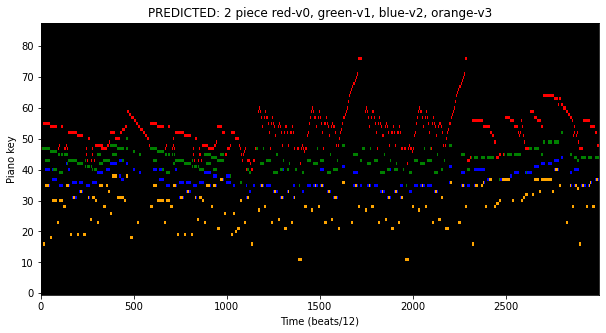

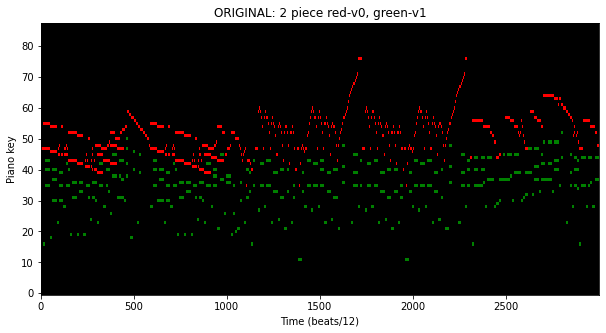

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 1
acc_0_2, sample 0: 0.9259259259259259
acc_1_2, sample 0: 0.6784492588369442
idx: 1


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=1 note=70 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=61 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=63 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: voice estimation
  from ipykernel import kernelapp as app


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


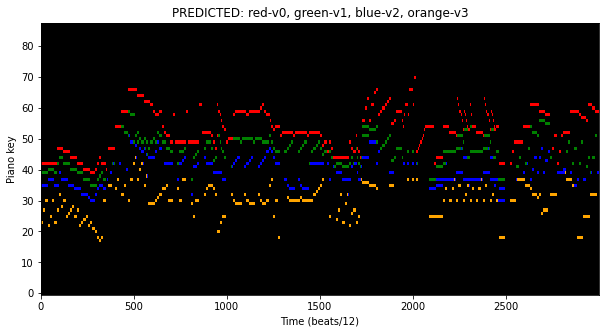

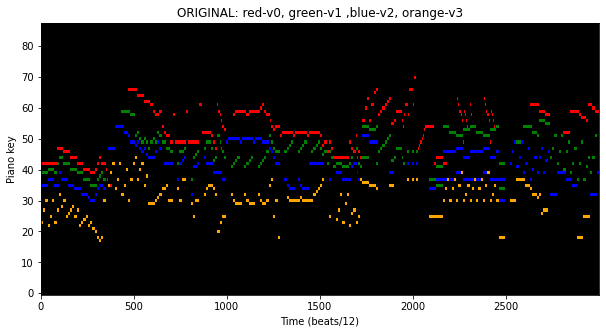

maximal overlap between gt voice 0 and pred 0, ACC 0.9800498753117207:
maximal overlap between gt voice 3 and pred 3, ACC 0.9651162790697675:
maximal overlap between gt voice 1 and pred 2, ACC 0.6080691642651297:
maximal overlap between gt voice 1 and pred 1, ACC 0.3400576368876081:
acc 0, sample 1: 0.9800498753117207
acc 1, sample 1: 0.3400576368876081
acc 2, sample 1: 0.31141868512110726
acc 3, sample 1: 0.9651162790697675
idx: 2


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=299
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


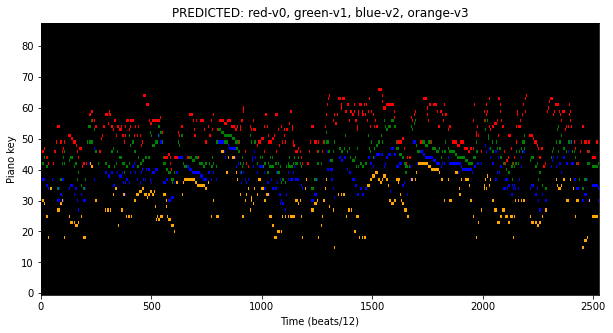

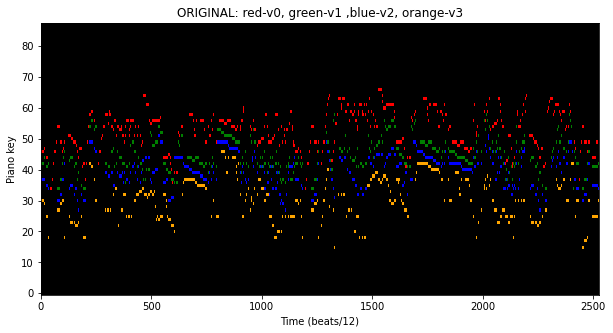

maximal overlap between gt voice 0 and pred 0, ACC 0.9263157894736842:
maximal overlap between gt voice 1 and pred 1, ACC 0.8456140350877193:
maximal overlap between gt voice 2 and pred 2, ACC 0.8038528896672504:
maximal overlap between gt voice 3 and pred 3, ACC 0.952755905511811:
acc 0, sample 2: 0.9263157894736842
acc 1, sample 2: 0.8456140350877193
acc 2, sample 2: 0.8038528896672504
acc 3, sample 2: 0.952755905511811
idx: 4


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=81 velocity=64 time=18
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=90 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=179
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=1 note=83 velocity=64 time=18
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=1 note=64 velocity=64 time=0
  warnings.warn("ignoring MIDI message

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


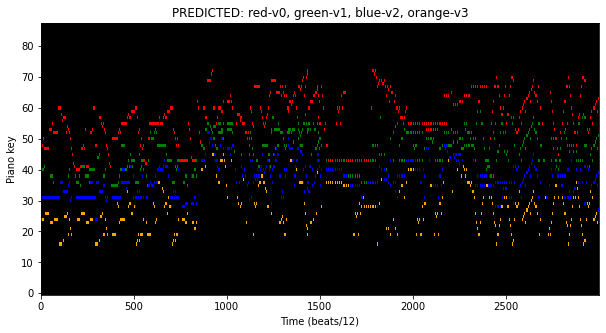

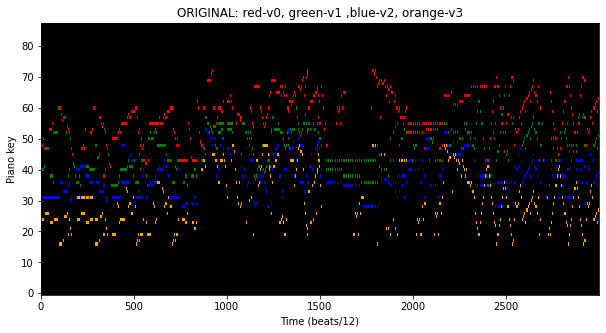

maximal overlap between gt voice 0 and pred 0, ACC 0.9774647887323944:
maximal overlap between gt voice 1 and pred 1, ACC 0.9024221453287197:
maximal overlap between gt voice 2 and pred 2, ACC 0.9046624913013221:
maximal overlap between gt voice 3 and pred 3, ACC 0.2140845070422535:
acc 0, sample 4: 0.9774647887323944
acc 1, sample 4: 0.9024221453287197
acc 2, sample 4: 0.9046624913013221
acc 3, sample 4: 0.2140845070422535
idx: 5


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=62 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=63 velocity=64 time=30
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=119
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=55 velocity=64 time=0
  warnings.warn("ignoring MIDI message %

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


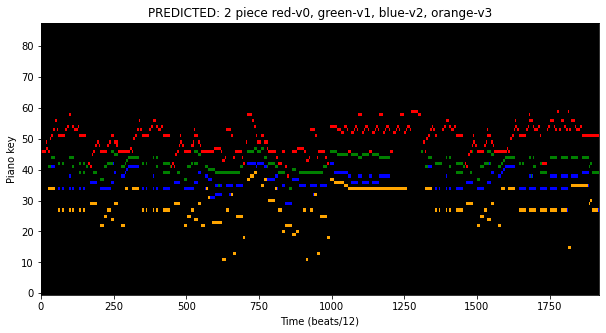

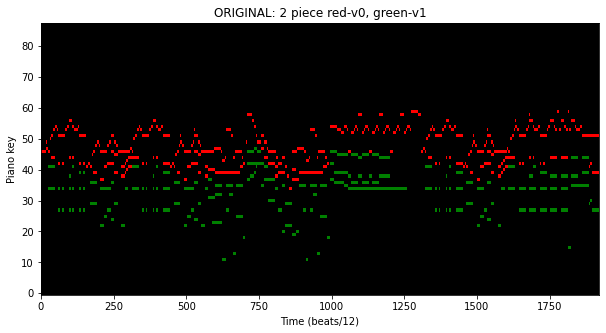

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 5: 0.6829268292682927
acc_1_2, sample 5: 0.45564516129032256
idx: 6


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=83 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=96 velocity=64 time=28
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


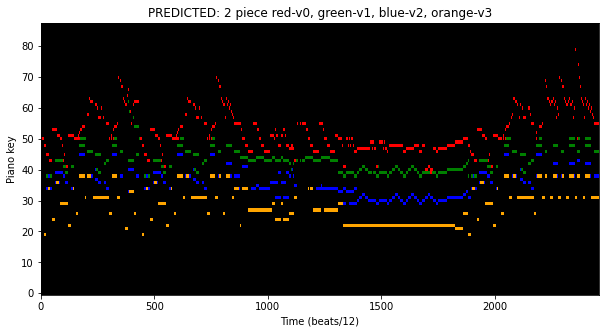

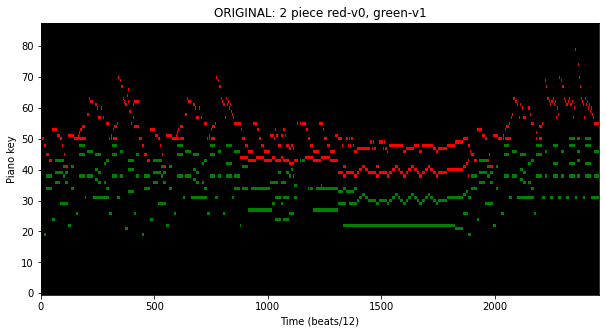

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 2
acc_0_2, sample 6: 0.7741116751269036
acc_1_2, sample 6: 0.38961038961038963
idx: 7


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=479
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


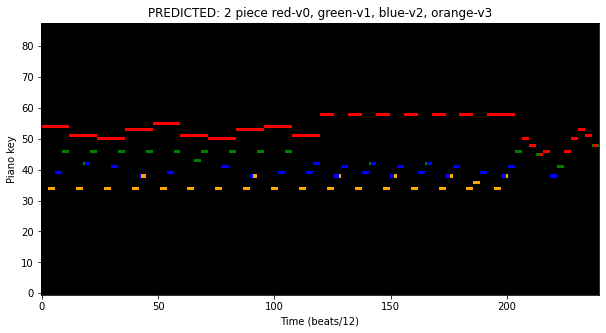

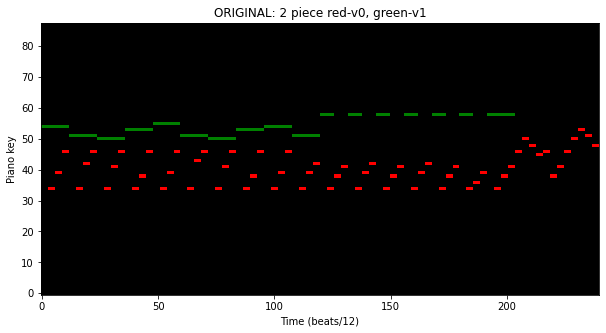

maximal overlap voice 0 and : 2
maximal overlap voice 1 and : 0
acc_0_2, sample 7: 0.3492063492063492
acc_1_2, sample 7: 1.0
idx: 8
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


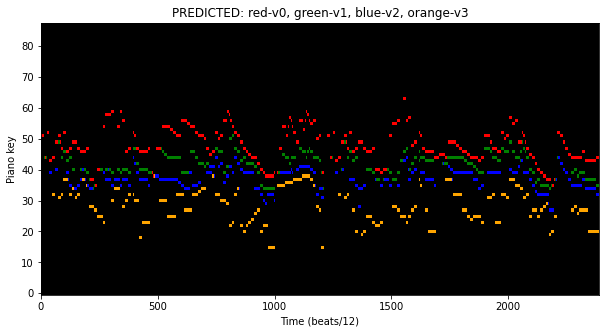

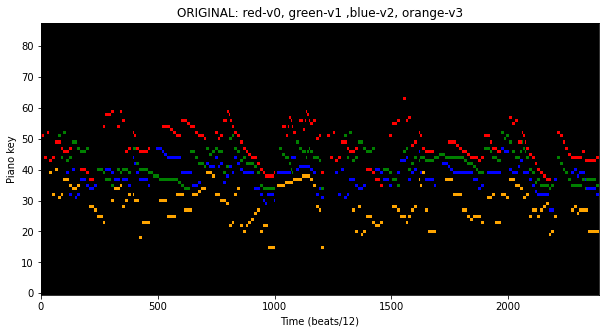

maximal overlap between gt voice 0 and pred 0, ACC 0.9463087248322147:
maximal overlap between gt voice 3 and pred 3, ACC 0.9224137931034483:
maximal overlap between gt voice 1 and pred 1, ACC 0.6783216783216783:
maximal overlap between gt voice 2 and pred 2, ACC 0.71900826446281:
acc 0, sample 8: 0.9463087248322147
acc 1, sample 8: 0.6783216783216783
acc 2, sample 8: 0.71900826446281
acc 3, sample 8: 0.9224137931034483
idx: 9


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=66 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


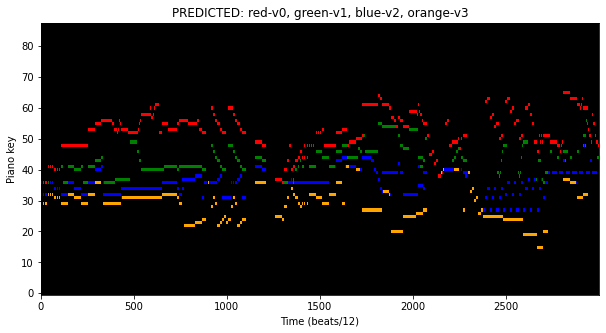

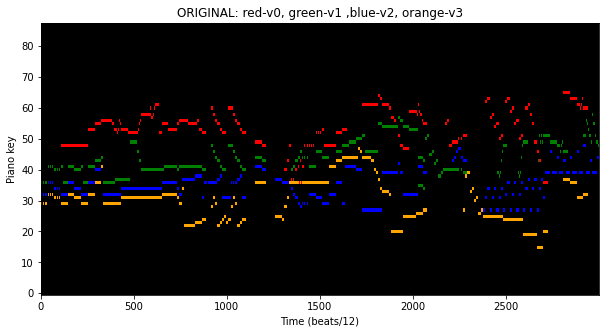

maximal overlap between gt voice 0 and pred 0, ACC 0.9754768392370572:
maximal overlap between gt voice 3 and pred 3, ACC 0.9652892561983472:
maximal overlap between gt voice 2 and pred 1, ACC 0.7526595744680851:
maximal overlap between gt voice 2 and pred 2, ACC 0.1981382978723404:
acc 0, sample 9: 0.9754768392370572
acc 1, sample 9: 0.15655339805825244
acc 2, sample 9: 0.1981382978723404
acc 3, sample 9: 0.9652892561983472
idx: 10


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=60 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=65 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=228
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=77 velocity=64 time=228
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=79 velocity=64 time=228
  warnings.warn("ignoring MIDI m

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


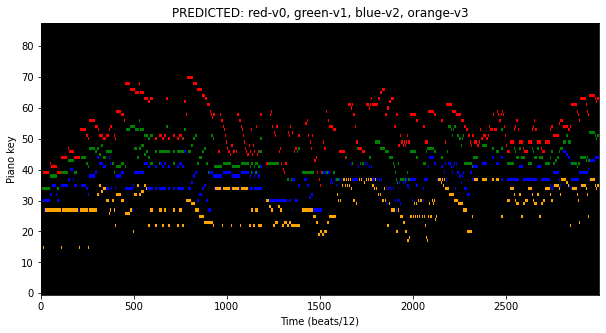

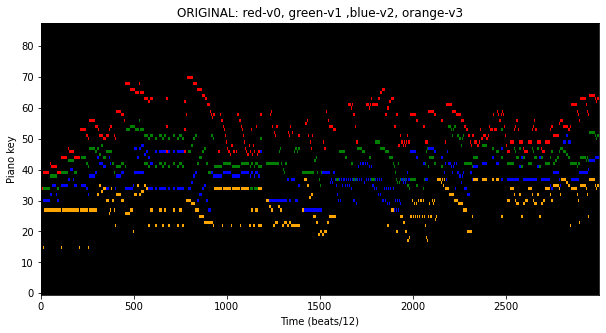

maximal overlap between gt voice 2 and pred 2, ACC 0.939938080495356:
maximal overlap between gt voice 0 and pred 0, ACC 0.9939271255060729:
maximal overlap between gt voice 1 and pred 1, ACC 0.93841059602649:
maximal overlap between gt voice 3 and pred 3, ACC 0.9814957594448728:
acc 0, sample 10: 0.9939271255060729
acc 1, sample 10: 0.93841059602649
acc 2, sample 10: 0.939938080495356
acc 3, sample 10: 0.9814957594448728
idx: 11
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


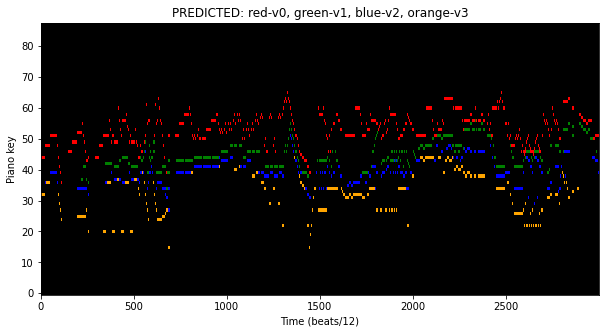

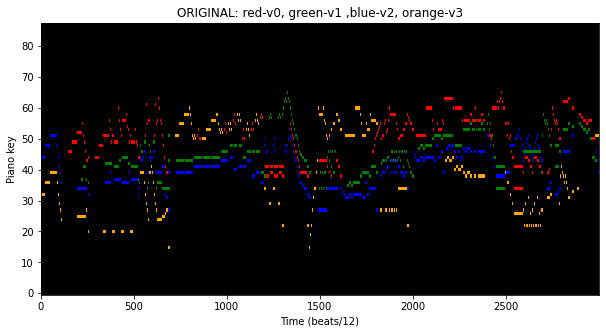

maximal overlap between gt voice 2 and pred 2, ACC 0.829136690647482:
maximal overlap between gt voice 0 and pred 0, ACC 0.921:
maximal overlap between gt voice 1 and pred 1, ACC 0.17077464788732394:
maximal overlap between gt voice 3 and pred 3, ACC 0.16292974588938713:
acc 0, sample 11: 0.921
acc 1, sample 11: 0.17077464788732394
acc 2, sample 11: 0.829136690647482
acc 3, sample 11: 0.16292974588938713
idx: 12
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


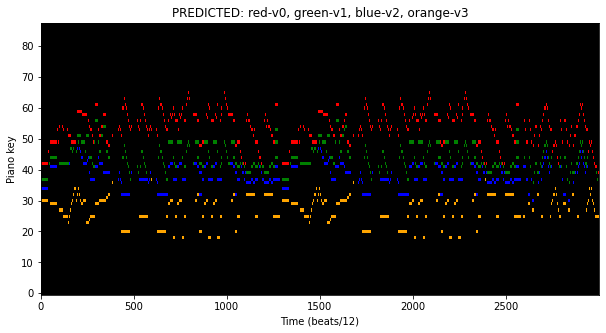

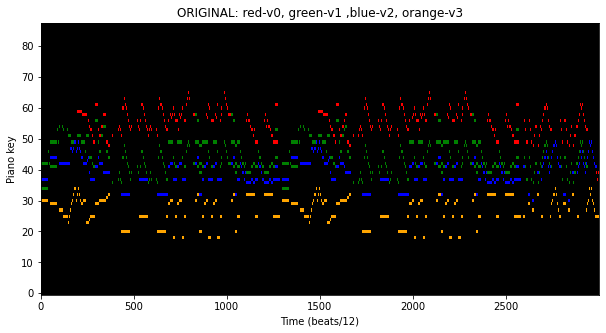

maximal overlap between gt voice 0 and pred 0, ACC 0.9394654088050315:
maximal overlap between gt voice 1 and pred 1, ACC 0.850177304964539:
maximal overlap between gt voice 3 and pred 3, ACC 1.0:
maximal overlap between gt voice 2 and pred 2, ACC 0.29609929078014185:
acc 0, sample 12: 0.9394654088050315
acc 1, sample 12: 0.850177304964539
acc 2, sample 12: 0.29609929078014185
acc 3, sample 12: 1.0
idx: 13


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=44 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


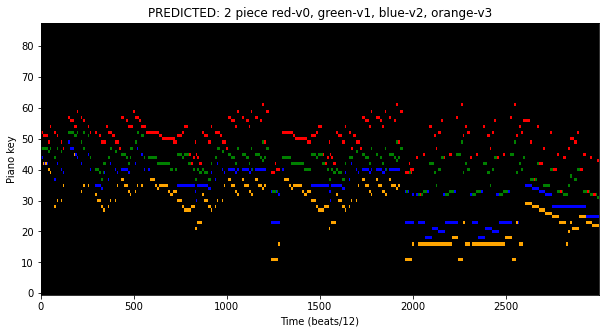

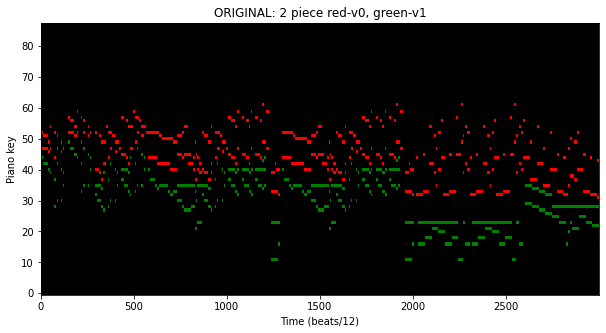

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 13: 0.7211155378486056
acc_1_2, sample 13: 0.7171717171717171
idx: 15


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=70 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


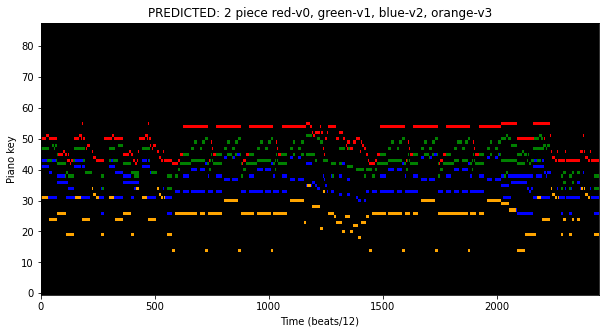

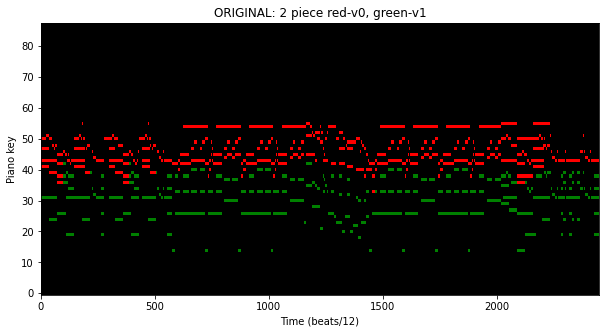

maximal overlap voice 0 and : 1
maximal overlap voice 1 and : 2
acc_0_2, sample 15: 0.4462809917355372
acc_1_2, sample 15: 0.49712643678160917
idx: 16


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=71 velocity=64 time=228
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=71 velocity=64 time=138
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=60 velocity=64 time=138
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=149
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=1 note=80 velocity=64 time=228
  warnings.warn("ignoring MIDI me

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


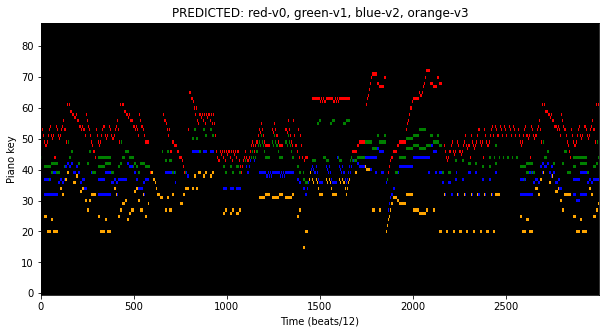

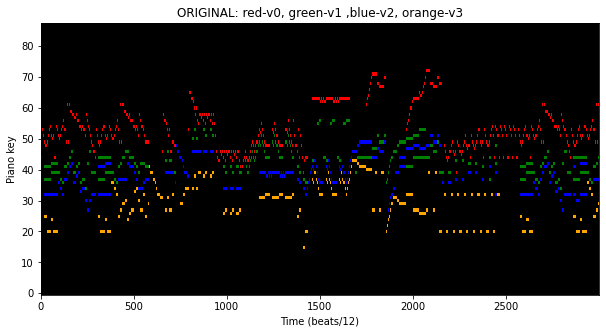

maximal overlap between gt voice 0 and pred 0, ACC 0.9844748858447488:
maximal overlap between gt voice 1 and pred 1, ACC 0.9072327044025157:
maximal overlap between gt voice 2 and pred 2, ACC 0.8858603066439523:
maximal overlap between gt voice 3 and pred 3, ACC 0.9489795918367347:
acc 0, sample 16: 0.9844748858447488
acc 1, sample 16: 0.9072327044025157
acc 2, sample 16: 0.8858603066439523
acc 3, sample 16: 0.9489795918367347
idx: 17
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


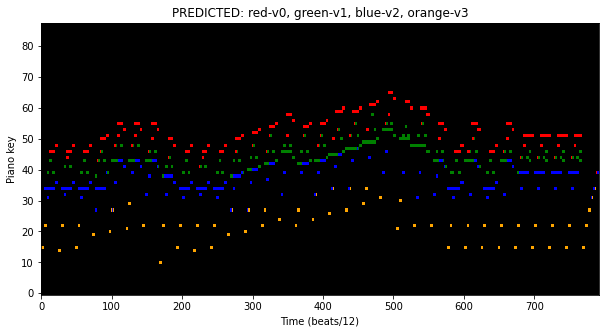

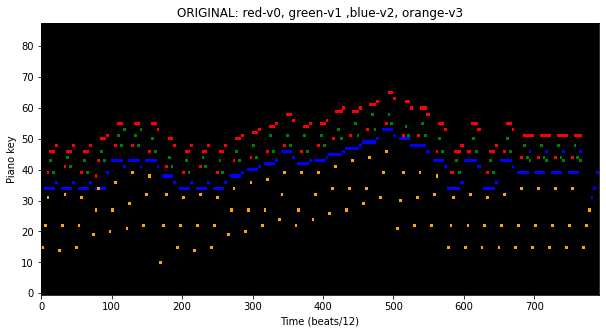

maximal overlap between gt voice 0 and pred 0, ACC 0.5403225806451613:
maximal overlap between gt voice 1 and pred 1, ACC 0.6875:
maximal overlap between gt voice 3 and pred 3, ACC 0.5757575757575758:
maximal overlap between gt voice 3 and pred 2, ACC 0.42424242424242425:
acc 0, sample 17: 0.5403225806451613
acc 1, sample 17: 0.6875
acc 2, sample 17: 0.4925373134328358
acc 3, sample 17: 0.5757575757575758
idx: 18
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


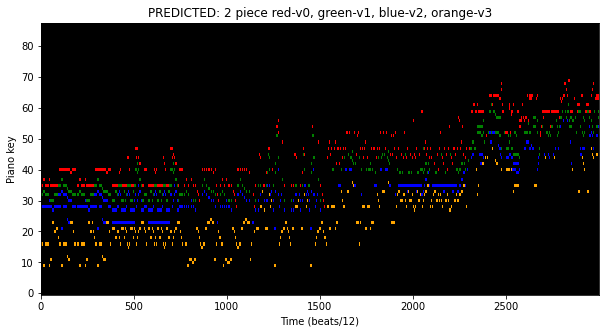

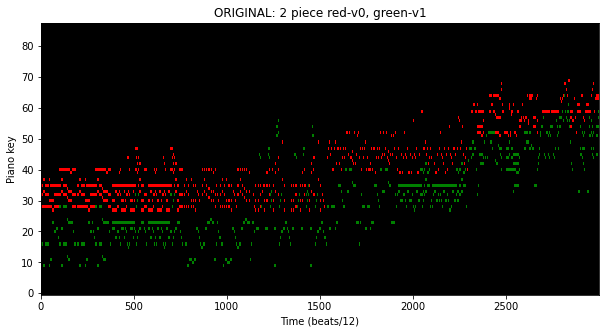

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 18: 0.6190476190476191
acc_1_2, sample 18: 0.37115839243498816
idx: 19


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=74 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=75 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=39 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=36 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=40 velocity=64 time=0
  warnings.warn("ignoring MIDI message %

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


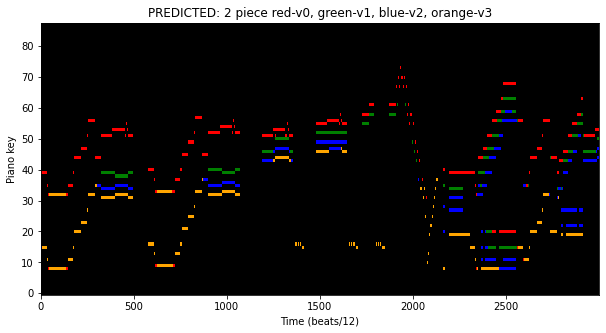

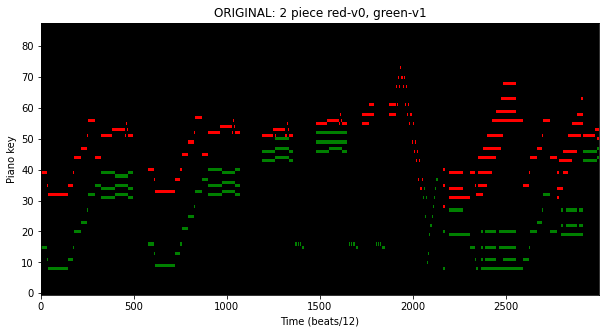

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 1
acc_0_2, sample 19: 0.9809873248832555
acc_1_2, sample 19: 0.9627937336814621
idx: 22


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=209
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


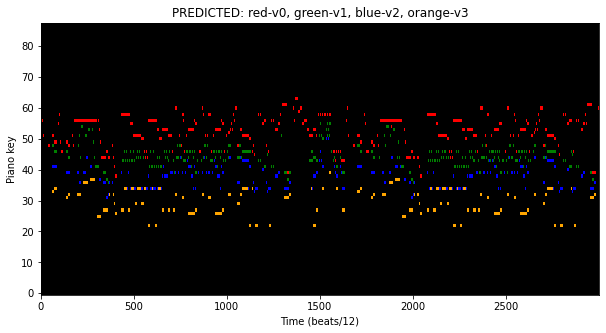

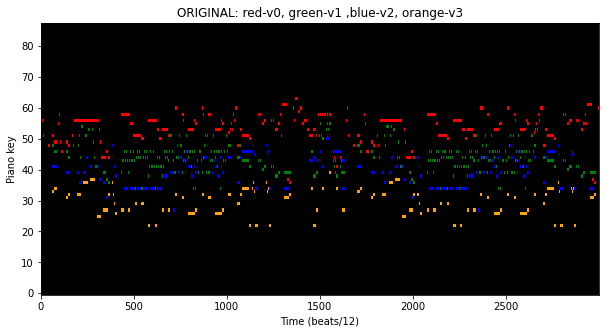

maximal overlap between gt voice 0 and pred 0, ACC 0.9705882352941176:
maximal overlap between gt voice 3 and pred 3, ACC 0.9642857142857143:
maximal overlap between gt voice 1 and pred 1, ACC 0.24205378973105135:
maximal overlap between gt voice 2 and pred 2, ACC 0.14981949458483754:
acc 0, sample 22: 0.9705882352941176
acc 1, sample 22: 0.24205378973105135
acc 2, sample 22: 0.14981949458483754
acc 3, sample 22: 0.9642857142857143
idx: 24


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=539
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


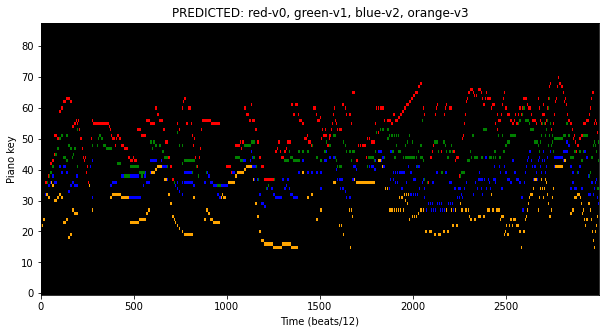

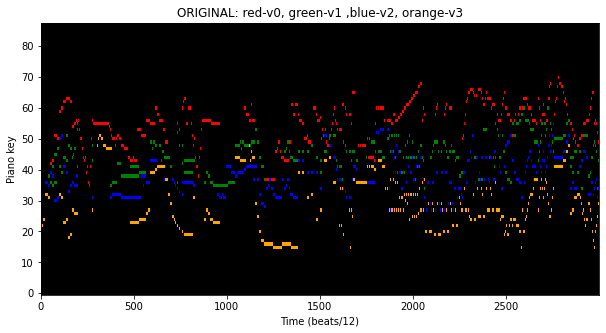

maximal overlap between gt voice 1 and pred 1, ACC 0.9301075268817204:
maximal overlap between gt voice 3 and pred 2, ACC 0.7858439201451906:
maximal overlap between gt voice 0 and pred 0, ACC 0.274672187715666:
maximal overlap between gt voice 3 and pred 3, ACC 0.20235934664246824:
acc 0, sample 24: 0.274672187715666
acc 1, sample 24: 0.9301075268817204
acc 2, sample 24: 0.16138763197586728
acc 3, sample 24: 0.20235934664246824
idx: 25


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=70 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=58 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


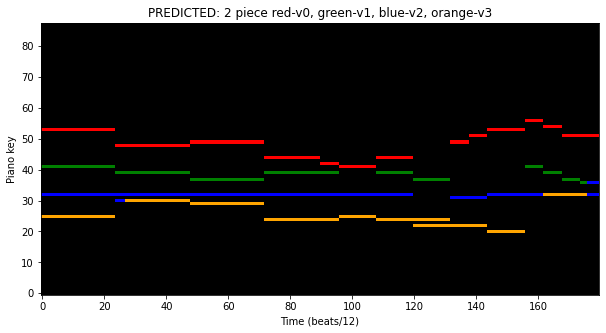

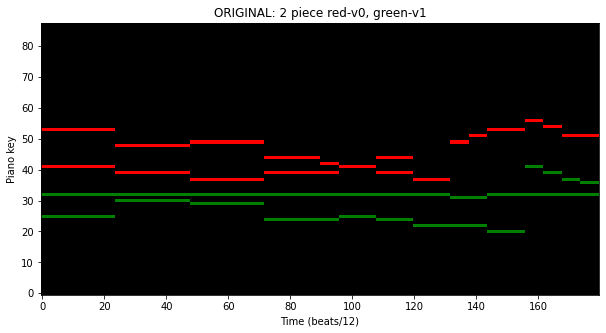

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 2
acc_0_2, sample 25: 0.6842105263157895
acc_1_2, sample 25: 0.4090909090909091
idx: 26
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


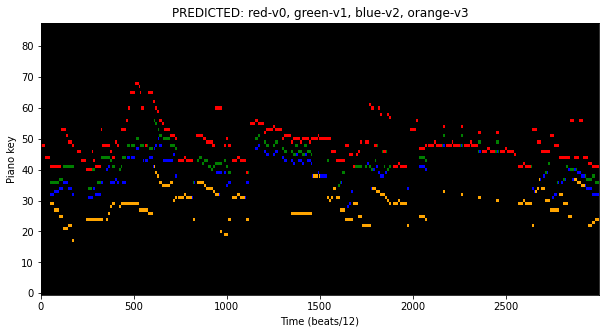

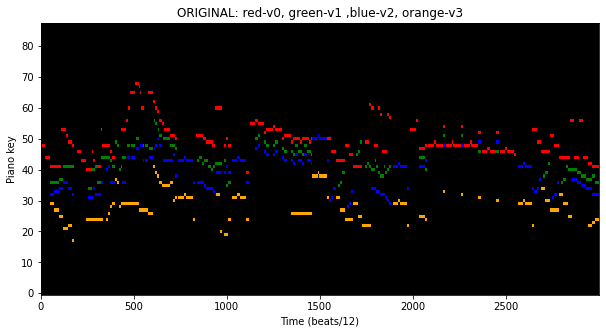

maximal overlap between gt voice 0 and pred 0, ACC 0.9815100154083205:
maximal overlap between gt voice 3 and pred 3, ACC 0.963718820861678:
maximal overlap between gt voice 1 and pred 1, ACC 0.7842696629213484:
maximal overlap between gt voice 2 and pred 2, ACC 0.7740492170022372:
acc 0, sample 26: 0.9815100154083205
acc 1, sample 26: 0.7842696629213484
acc 2, sample 26: 0.7740492170022372
acc 3, sample 26: 0.963718820861678
idx: 27
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


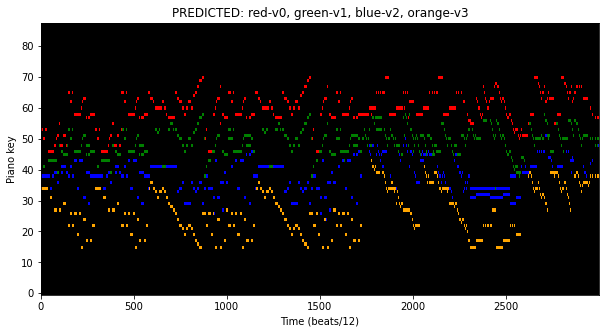

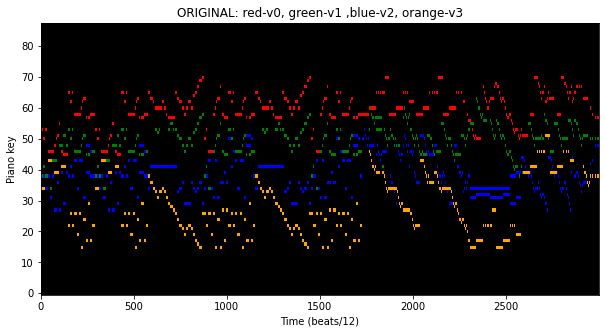

maximal overlap between gt voice 0 and pred 0, ACC 0.9836363636363636:
maximal overlap between gt voice 1 and pred 1, ACC 0.9276190476190476:
maximal overlap between gt voice 3 and pred 3, ACC 0.9162790697674419:
maximal overlap between gt voice 2 and pred 2, ACC 0.3198458574181118:
acc 0, sample 27: 0.9836363636363636
acc 1, sample 27: 0.9276190476190476
acc 2, sample 27: 0.3198458574181118
acc 3, sample 27: 0.9162790697674419
idx: 28
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


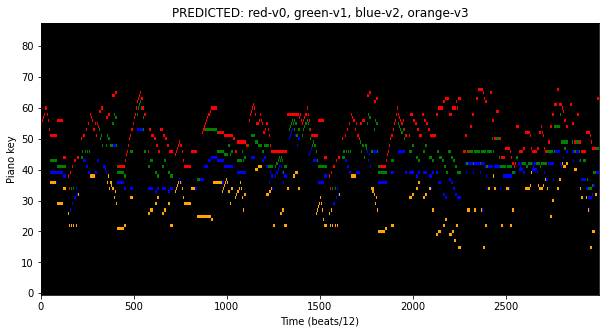

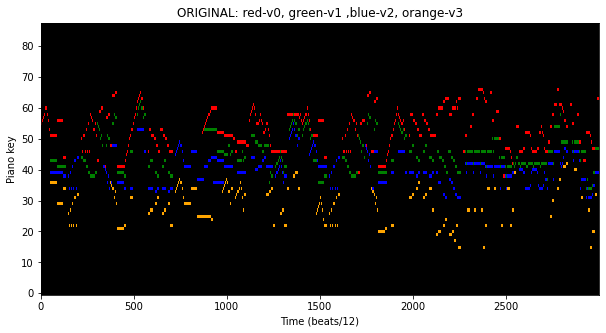

maximal overlap between gt voice 0 and pred 0, ACC 0.9342857142857143:
maximal overlap between gt voice 1 and pred 1, ACC 0.7828282828282829:
maximal overlap between gt voice 2 and pred 2, ACC 0.7588235294117647:
maximal overlap between gt voice 3 and pred 3, ACC 0.9526315789473684:
acc 0, sample 28: 0.9342857142857143
acc 1, sample 28: 0.7828282828282829
acc 2, sample 28: 0.7588235294117647
acc 3, sample 28: 0.9526315789473684
idx: 29
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


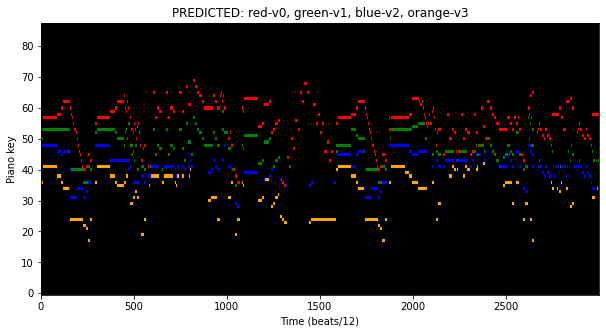

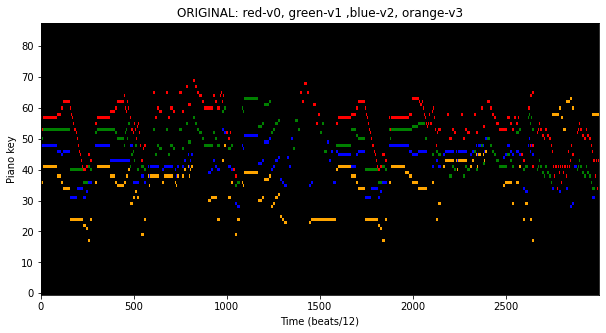

maximal overlap between gt voice 0 and pred 0, ACC 0.6580310880829016:
maximal overlap between gt voice 1 and pred 1, ACC 0.45255474452554745:
maximal overlap between gt voice 3 and pred 3, ACC 0.4669260700389105:
maximal overlap between gt voice 1 and pred 2, ACC 0.40145985401459855:
acc 0, sample 29: 0.6580310880829016
acc 1, sample 29: 0.45255474452554745
acc 2, sample 29: 0.4146341463414634
acc 3, sample 29: 0.4669260700389105
idx: 30


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=68 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


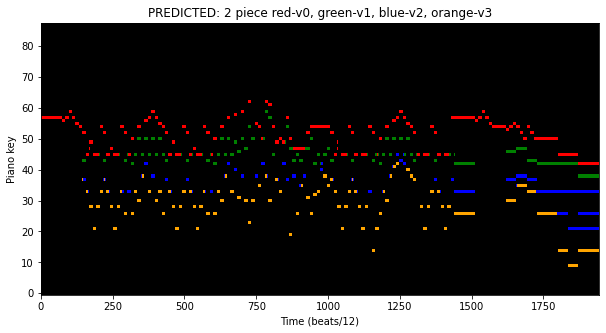

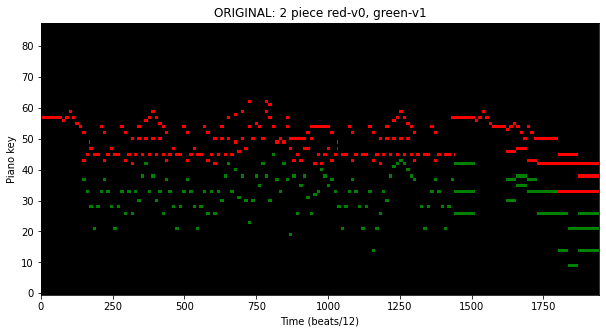

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 30: 0.6373056994818653
acc_1_2, sample 30: 0.688
idx: 32
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


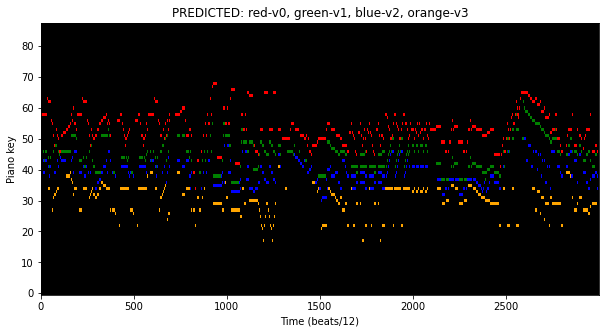

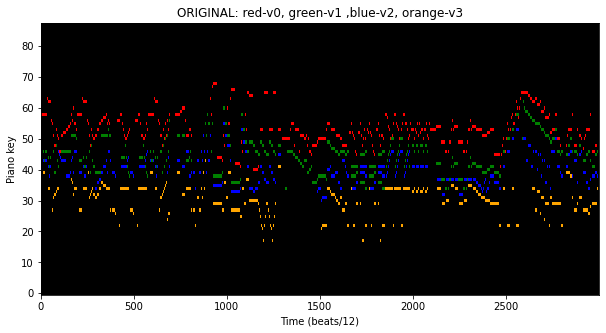

maximal overlap between gt voice 0 and pred 0, ACC 0.9818308874912649:
maximal overlap between gt voice 2 and pred 2, ACC 0.9479166666666666:
maximal overlap between gt voice 1 and pred 1, ACC 0.21792114695340503:
maximal overlap between gt voice 3 and pred 3, ACC 0.2838569880823402:
acc 0, sample 32: 0.9818308874912649
acc 1, sample 32: 0.21792114695340503
acc 2, sample 32: 0.9479166666666666
acc 3, sample 32: 0.2838569880823402
idx: 33


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=60
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=80 velocity=64 time=60
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=71 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=52 velocity=64 time=60
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=53 velocity=64 time=60
  warnings.warn("ignoring MIDI messa

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


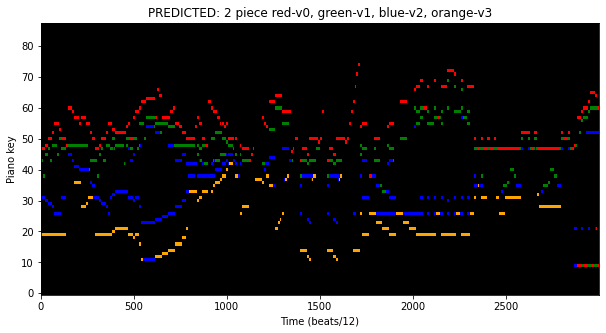

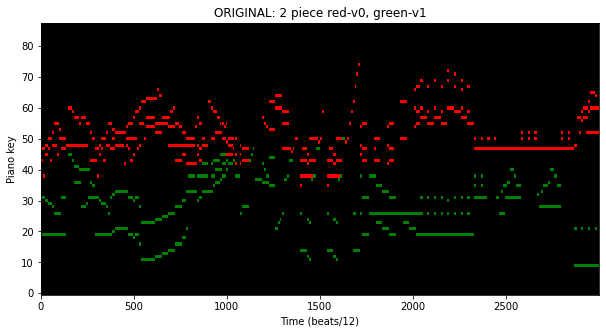

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 2
acc_0_2, sample 33: 0.797752808988764
acc_1_2, sample 33: 0.8111510791366906
idx: 36


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=71 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=68 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


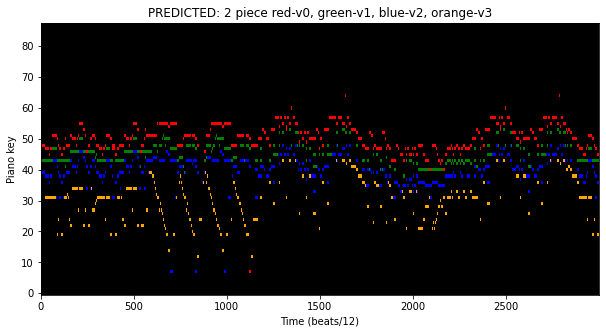

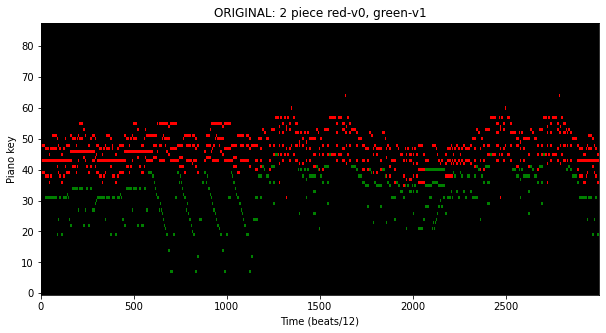

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 36: 0.5711229946524065
acc_1_2, sample 36: 0.7801418439716312
idx: 37


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=65 velocity=64 time=30
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=72 velocity=64 time=30
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=76 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=59 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


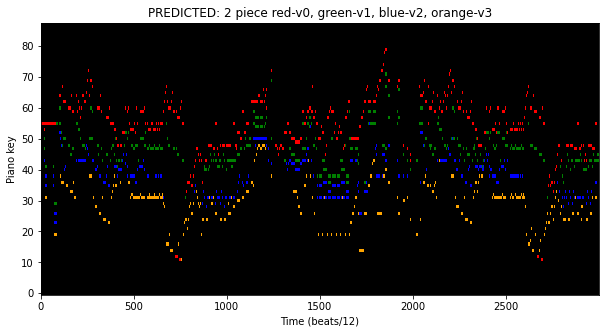

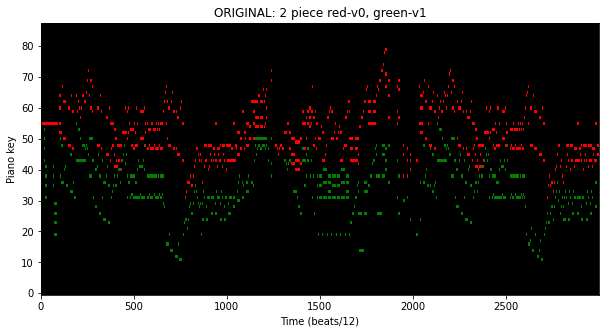

maximal overlap voice 0 and : 1
maximal overlap voice 1 and : 2
acc_0_2, sample 37: 0.8061950606948514
acc_1_2, sample 37: 0.8251273344651953
idx: 38


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=65 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=60 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=66 velocity=64 time=28
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=68 velocity=64 time=28
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=28
  warnings.warn("ignoring MIDI messag

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


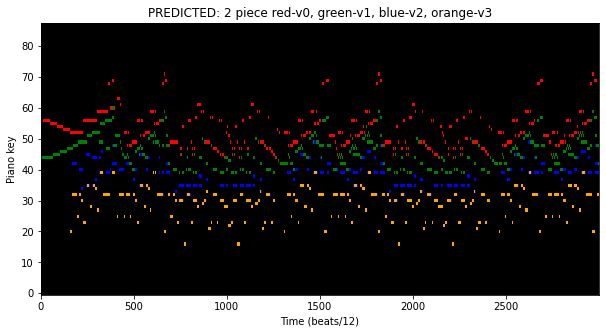

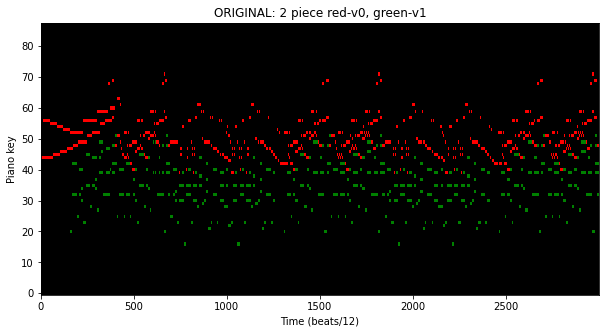

maximal overlap voice 0 and : 1
maximal overlap voice 1 and : 3
acc_0_2, sample 38: 0.692876965772433
acc_1_2, sample 38: 0.002944062806673209
idx: 39
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


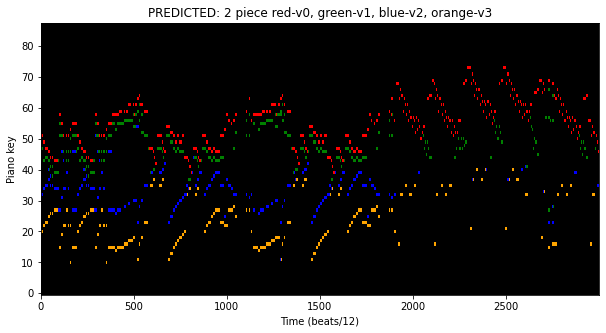

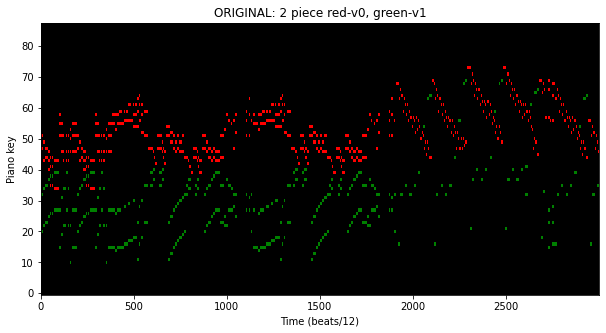

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 2
acc_0_2, sample 39: 0.7775030902348579
acc_1_2, sample 39: 0.6925925925925925
idx: 40


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=419
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=48 velocity=64 time=60
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


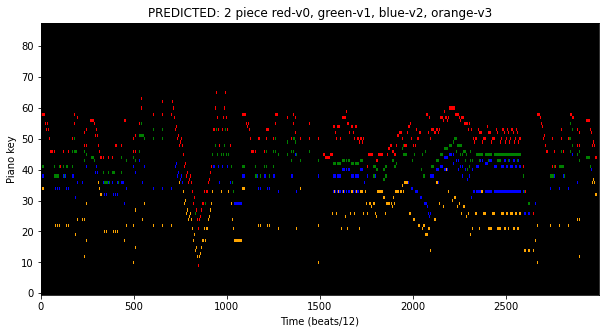

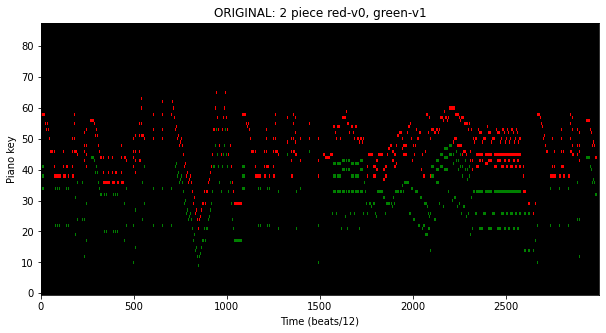

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 40: 0.8801825789273487
acc_1_2, sample 40: 0.8580183861082737
idx: 42


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=64 time=30
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=50 velocity=64 time=45
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=45 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=56 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=2 note=44 velocity=64 time=108
  warnings.warn("ignoring MIDI mes

prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


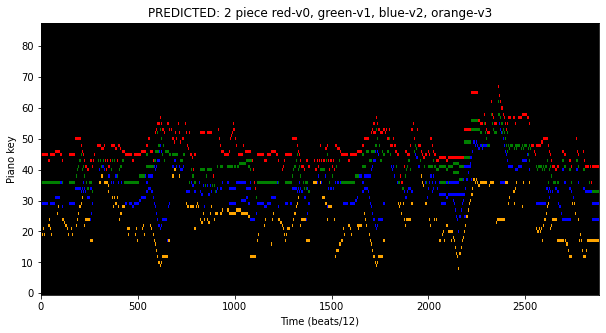

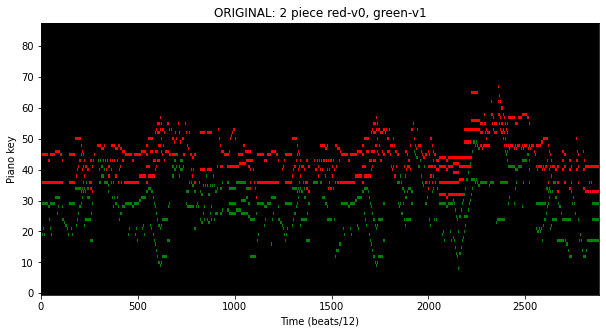

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 3
acc_0_2, sample 42: 0.4431314623338257
acc_1_2, sample 42: 0.5464231354642314
idx: 43


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=65 velocity=64 time=18
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=72 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=67 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


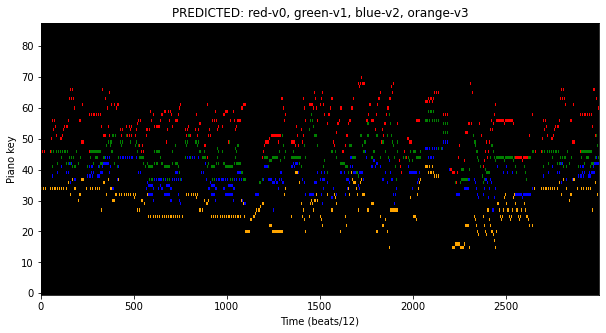

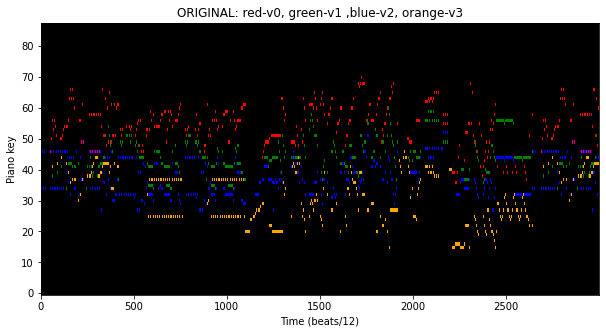

maximal overlap between gt voice 0 and pred 0, ACC 0.9662288930581614:
maximal overlap between gt voice 1 and pred 1, ACC 0.9563106796116505:
maximal overlap between gt voice 3 and pred 2, ACC 0.8487534626038781:
maximal overlap between gt voice 3 and pred 3, ACC 0.13130193905817175:
acc 0, sample 43: 0.9662288930581614
acc 1, sample 43: 0.9563106796116505
acc 2, sample 43: 0.11335474988526847
acc 3, sample 43: 0.13130193905817175
idx: 44


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=70 velocity=64 time=20
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=62 velocity=64 time=39
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=74 velocity=64 time=48
  warnings.warn("ignoring MIDI message %s" % msg)


prediction number of voices: tensor(4)
prediction number of voices: tensor(4)


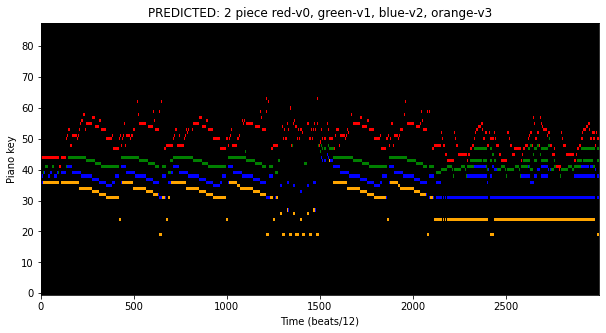

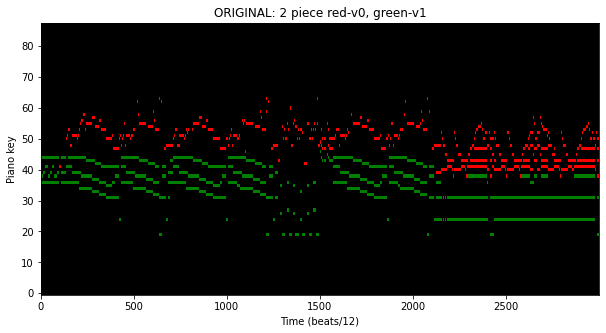

maximal overlap voice 0 and : 0
maximal overlap voice 1 and : 2
acc_0_2, sample 44: 0.7816593886462883
acc_1_2, sample 44: 0.5900755124056095
acc_0_2: 0.6984190460606066
acc_1_2: 0.6264177747694022
acc_0: 0.8853105224089219
acc_1: 0.6539293904464945
acc_2: 0.5566935335394897
acc_3: 0.6983434411965718


In [48]:
dict_pred , dict_gt, acc_0_2, acc_1_2, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)

print("acc_0_2:",acc_0_2)
print("acc_1_2:",acc_1_2)
print("acc_0:",acc_0)
print("acc_1:",acc_1)
print("acc_2:",acc_2)
print("acc_3:",acc_3)

# Accuracy mixed all voices (old)

In [ ]:
def evaluate_accuracy_polyphonic(model, train_dataloader, part_dic):

    unitl_len_idx = max_len_load
    path_parts = "AI-MA_project/polyphonic_new"
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
                                      
                #print("nbr_voices:",nbr_voices)
        if idx >30 and idx not in [0, 7, 21, 32, 35]: 
            #if nbr_voices == 2:
                
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                

                list_of_note_arrays = [note_array_0,note_array_1]

                if len(part)== 4:
                    part_2 = part[2]
                    note_array_2 = partitura.utils.note_array_from_part(part_2)

                    part_3 = part[3]
                    note_array_3 = partitura.utils.note_array_from_part(part_3)
                    list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)

                    

                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]
                        print("prediction clf:",prediction_clf)


                
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          #print("stop",end_first)
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)

                        #print("pred_list",str(label),len(pred_list_first),pred_list_first)
                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")
                          print("total_predictions_dict",str(label),len(pred_list_first),pred_list_first)




                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                  counting = 0
                  for j in range(len(total_predictions_dict[i])):
                      if total_predictions_dict[i][j][0] == gt:         
                        counting +=1
                  count_dict_2[i].append(counting)



                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                

                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                

                if len(list_of_note_arrays)==4:
                    acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                    print("acc 2, sample {}:".format(idx),acc_2)
                    acc_score_dict["2"].append(acc_2)

                    acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                    print("acc 3, sample {}:".format(idx),acc_3)
                    acc_score_dict["3"].append(acc_3)


                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                

                
    print("total_predictions_dict",total_predictions_dict.keys())

    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])

In [ ]:
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic(model,val_dataloader,part_dic=file_names_part)


print("acc_0:",acc_0)
print("acc_1:",acc_1)
print("acc_2:",acc_2)
print("acc_3:",acc_3)